In [1]:
from pickle import loads
from os.path import isfile
from itertools import chain
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.legendre import Legendre
from cytoolz import pipe, partial
from pymongo import MongoClient
from lmfit.models import ExpressionModel, ConstantModel
from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import curve_fit

from vmitools import (
    finite_legendre_transform_in_theta,
    interp, tohist, transpose_to_drdomega, transpose_to_drdth,
)
import phase_shifts

In [2]:
dataset = "good2"
runinfo = (
    pd
    .read_excel("Data/Run list.xlsx", sheet_name="Runs", index_col="Dataset")
    .loc[dataset]
    .set_index("Run", drop=False)
)
runinfo

,Run,Opt phase (mach unit)
Run,,
463,463,0.10
465,465,0.25
466,466,0.40
467,467,0.55
469,469,0.85
470,470,1.00
471,471,1.15
472,472,1.30
473,473,1.45


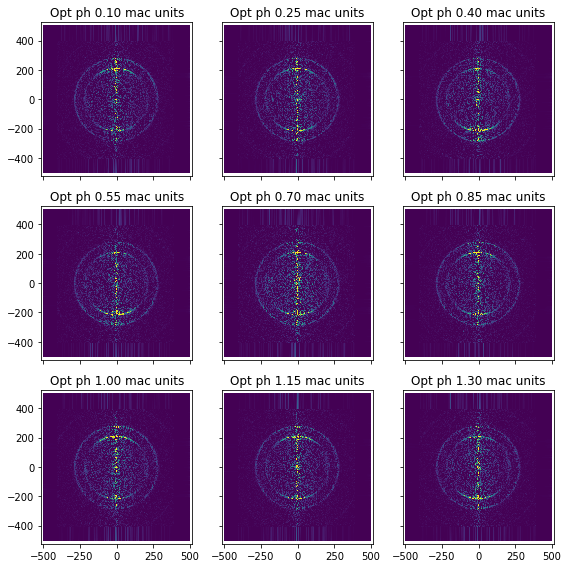

In [3]:
db = MongoClient('mongodb')['FERMI_20144077']


def _average(d: pd.DataFrame) -> pd.Series:
    return pd.Series({
        "Edges": d["Edges"].iloc[0],
        "N shots": d["N shots"].sum(),
        "Reduced img": (d["Reduced img"] * d["N shots"]).sum() / d["N shots"].sum(),
    })


groupped = (
    pd.DataFrame(
        [
            {
                "Run": d["run"],
                "N shots": d["n"],
                "Edges": loads(d["edges"]),
                "Reduced img": loads(d["hist"]),
            }
        for d in db['reconstructed'].find({'run': {'$in': runinfo["Run"].tolist()}})]
    )
    .set_index("Run")
    .merge(runinfo, left_index=True, right_index=True)
    .groupby("Opt phase (mach unit)")
    .apply(_average)
)


plt.figure(figsize=(8, 8))
i = 0
for ph, edges, img in groupped[["Edges", "Reduced img"]].itertuples():
    i += 1
    if i > 9:
        break
    plt.subplot(3, 3, i)
    plt.title(f"Opt ph {ph:0.2f} mac units")
    plt.pcolormesh(edges, edges, img.T)
    plt.axis("equal")
    plt.clim(0, 0.05)
    plt.gca().label_outer()
plt.tight_layout()
plt.show()

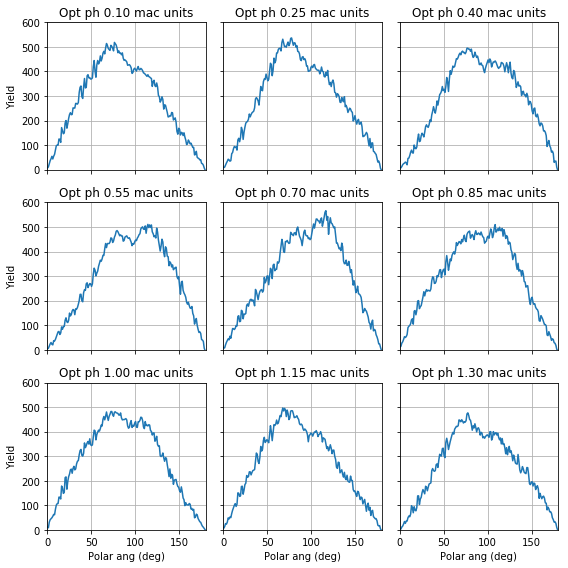

In [4]:
def centers(arr):
    return (arr[1:]+arr[:-1])/2


redges, thedges = np.linspace(0, 500, 501), np.linspace(-np.pi, np.pi, 361)
r, th = centers(redges), centers(thedges)
thdeg = th / np.pi * 180
fr, to = 282.2-12.16*2, 282.2+12.16*2


def _project(d: pd.Series) -> pd.Series:
    zedges = d["Edges"]
    inverted = d["Reduced img"]
    
    # Transpose to other spaces
    sliced = interp(gaussian_filter(inverted, 3), zedges, zedges)  # (rho, z) -> intensity
    # hist_indrdomega = tohist(transpose_to_drdomega(sliced), redges, thedges)  # (r, th) -> intensity
    hist_indrdth = tohist(transpose_to_drdth(sliced), redges, thedges)  # (r, th) -> intensity
    where = (fr < r) & (r < to)
    return pd.Series({
        "Ang dist": hist_indrdth[where].sum(0),
    })


projected = groupped.apply(_project, axis=1)


plt.figure(figsize=(8, 8))
i = 0
for ph, dist in projected[["Ang dist"]].itertuples():
    i += 1
    if i > 9:
        break
    plt.subplot(3, 3, i)
    plt.title(f"Opt ph {ph:0.2f} mac units")
    plt.xlabel("Polar ang (deg)")
    plt.ylabel("Yield")
    plt.plot(thdeg, dist)
    plt.grid(True)
    plt.xlim(0, 180)
    plt.ylim(0, 600)
    plt.gca().label_outer()
plt.tight_layout()
plt.show()

In [5]:
def _sum(d: pd.Series):
    dth = 5
    dist = d["Ang dist"]
    return [
        {
            "Opt phase (mach unit)": d.name,
            "Yield": dist[(fr <= thdeg) & (thdeg < fr + dth)].sum(),
            "Polar ang fr (deg)": fr,
            "Polar ang to (deg)": fr + dth,
        }
        for fr in np.arange(0, 180, dth)
    ]


summed = pd.DataFrame([d for d in chain.from_iterable(projected.apply(_sum, axis=1))])
summed.head()

,Opt phase (mach unit),Polar ang fr (deg),Polar ang to (deg),Yield
0,0.1,0,5,123.034604
1,0.1,5,10,294.512511
2,0.1,10,15,546.518591
3,0.1,15,20,737.338330
4,0.1,20,25,954.188684


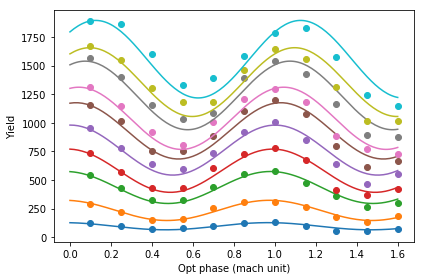

In [6]:
grouped_fr = {k: d for k, d in summed.groupby("Polar ang fr (deg)")}
grouped_to = {180 - k: d for k, d in summed.groupby("Polar ang to (deg)")}
fit = [
    {
        "Model result": {
            "Expr": "[Yield] = amp * cos(freq * [Opt phase (mach unit)] - shift) + offset",
            "Params": phase_shifts.fit(grouped_fr[k], grouped_to[k]),
        },
        "Polar ang fr (deg)": d["Polar ang fr (deg)"].tolist()[0],
        "Polar ang to (deg)": d["Polar ang to (deg)"].tolist()[0],
    }
    for k, d in grouped_fr.items()
]


x = np.linspace(0, 1.6, 161)
colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
]

plt.figure()
plt.xlabel("Opt phase (mach unit)")
plt.ylabel("Yield")

for c, d in zip(colors, fit):
    f = phase_shifts.load(d["Model result"]["Params"])
    plt.plot(x, f(x), color=c)
    
    g = grouped_fr[d["Polar ang fr (deg)"]]
    plt.plot(g["Opt phase (mach unit)"], g["Yield"], "o", color=c)

plt.tight_layout()
plt.show()

In [7]:
with open(f"Data/Photoelectron yields - {dataset}.json", "w") as fp:
    json.dump({
        "Dataset": dataset,
        "Data": summed.to_dict("records"),
        "Grouped by": {
            "Polar ang fr (deg)": fit,
        },
    }, fp, indent=2, sort_keys=True)